In [1]:
from __future__ import print_function, division

In [2]:
import torch

In [3]:
import torch.nn as nn

In [4]:
import torch.optim as optim

In [5]:
from torch.autograd import Variable

In [6]:
import numpy as np

In [7]:
import torchvision

In [8]:
from torchvision import datasets, models, transforms

In [9]:
import matplotlib.pyplot as plt

In [10]:
import time

In [11]:
import copy

In [12]:
import os

In [13]:
plt.ion()

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [15]:
data_dir = 'hymenoptera_data'

In [16]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}


In [17]:
dsets

{'train': <torchvision.datasets.folder.ImageFolder at 0x7fdaad8e15c0>,
 'val': <torchvision.datasets.folder.ImageFolder at 0x7fdaad8e1898>}

In [18]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
use_gpu = torch.cuda.is_available()

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [20]:
inputs, classes = next(iter(dset_loaders['train']))

In [21]:
out = torchvision.utils.make_grid(inputs)

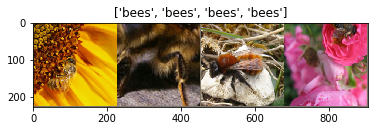

In [22]:
imshow(out, title=[dset_classes[x] for x in classes])

In [23]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()
    
    best_model = model
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dset_loaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [24]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decap_epoch=7):
    lr = init_lr * (0.1**(epoch // lr_decap_epoch))
    
    if epoch % lr_decap_epoch == 0:
        print("LR is set to {}".format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return optimizer

In [25]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return
    

In [26]:
model_ft = models.resnet18(pretrained=True)

In [27]:
num_ftrs = model_ft.fc.in_features

In [28]:
model_ft.fc = nn.Linear(num_ftrs, 2)

In [29]:
if use_gpu:
    model_ft = model_ft.cuda()

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001


RuntimeError: CUDNN_STATUS_ARCH_MISMATCH